In [116]:
import sys
if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import pyfilaments.analysisutils as analysis
from tqdm import tqdm
import pandas as pd
import h5py

%matplotlib notebook
plt.close('all')

# Figure parameters
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import cm
from tqdm import tqdm


# Create a folder for storing Publication figures

publication_figures = '/home/deepak/Dropbox/LacryModeling/ActiveFilamentsManuscript/Figures/Figure4'

import _figure_parameters


In [74]:
# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23']

data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrengthSweep_FineResolution']

In [75]:
# Find all analysis data files and create a list
files_list = []
 # Walk through the folders and identify the simulation data files

for data_folder in data_folders:
    for dirs, subdirs, files in os.walk(data_folder, topdown=False):

        root, subFolderName = os.path.split(dirs)

        for fileNames in files:
            if(fileNames.endswith('hdf5') and fileNames[0] != '.' and 'analysis' in fileNames):
                files_list.append(os.path.join(dirs,fileNames))

print('No:of files: {}'.format(len(files_list)))

No:of files: 50


In [90]:
# Build a data frame with all the data and the parameter of interest
# Collect all data into a single data frame
df = pd.DataFrame({})
# parameter = 'spring constant'
parameter = 'activity number'
# parameter = 'potDipole strength'

for file in files_list:
    
    with h5py.File(file, "r") as f:
        if('analysis data' in f.keys()): # Load the simulation data (newer method)
                    
            dset = f['analysis data']
            
            if(dset.attrs['Sim complete']==True):
                parameter_value = dset.attrs[parameter]
                
                period = dset.attrs['period']
                if(np.isnan(period)):
                    period = 'aperiodic'
                tip_angles = dset['Tip angles'][:]
                
                filament_behavior = dset.attrs['filament behavior']

                df_file = pd.DataFrame({parameter:np.repeat(parameter_value, len(tip_angles),axis=0), 'Base-Tip angles':tip_angles,'period':np.repeat(period, len(tip_angles),axis=0), 'filament behavior':np.repeat(filament_behavior, len(tip_angles),axis=0)})
                
              
                df = df.append(df_file, ignore_index=True)

<IPython.core.display.Javascript object>


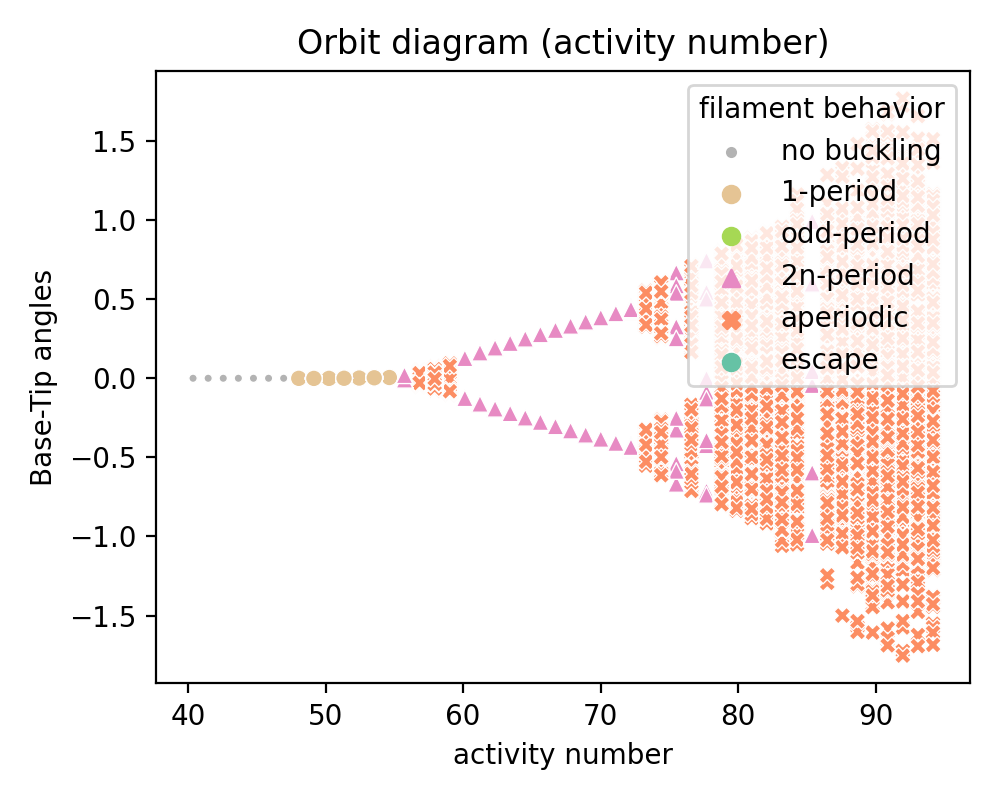

In [117]:
# Plot orbit diagram of filament base-tip angles (orbit point: phase=0 (end of extension, start of compression))
# Choose a consistent color-map and markers for filament behaviors
categories = ['no buckling', '1-period', 'odd-period','2n-period','aperiodic','escape']
markers = {'no buckling':'.', '1-period':'o','2n-period':'^','aperiodic':'X'}

cmap = plt.cm.get_cmap('Set2_r', 255)
linear_array = np.linspace(0,1,len(categories))
colors={}
for ii, cat in enumerate(categories):
    
    colors[cat]=cmap(linear_array[ii])
                           
save = False
style_parameter = 'filament behavior'

df['Base-tip angles (deg)'] = df['Base-Tip angles']*180/np.pi

# plt.style.use('default')
title = 'Orbit diagram ({})'.format(parameter)
plt.figure(figsize=(5,4))
sns.scatterplot(data = df, x = parameter, y = 'Base-Tip angles', hue = style_parameter, style = style_parameter, 
                estimator = None, legend= True, rasterized = True, hue_order = categories, markers = markers, palette = colors)
# sns.scatterplot(x = parameter, y = 'Base-Tip angles' , data = df,
#                 estimator = None, legend= True, palette = 'bright', rasterized = True, color = 'k', s=20)
plt.title(title)
plt.tight_layout()
# plt.yticks([-135, -90, -45, 0, 45, 90, 135])
if(save):
    plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)
plt.show()

In [61]:
# Save the Orbit map DataFrame
processed_data_folder = '/home/deepak/Dropbox/LacryModeling/processed_data/figures'
file = 'OrbitMap.csv'
df.to_csv(os.path.join(processed_data_folder, file))

In [120]:
# Fixed points based on Single-cycle prediction

# Plot the bifurcation diagram of the system
fixed_pts_data_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_sweep_FINAL/FixedPointAnalysis'


files = os.listdir(fixed_pts_data_folder)

df_combined = pd.DataFrame({})

for ii, file in enumerate(files):
    
    if file.endswith('.csv'):
        df_temp = pd.read_csv(os.path.join(fixed_pts_data_folder, file))
        
        if df_temp['activity number'][0]<=95 and df_temp['activity number'][0]>=40:
            
            
            df_combined = df_combined.append(df_temp)

In [121]:
df_combined['Fixed points -ve'] = -df_combined['Fixed point']

<IPython.core.display.Javascript object>


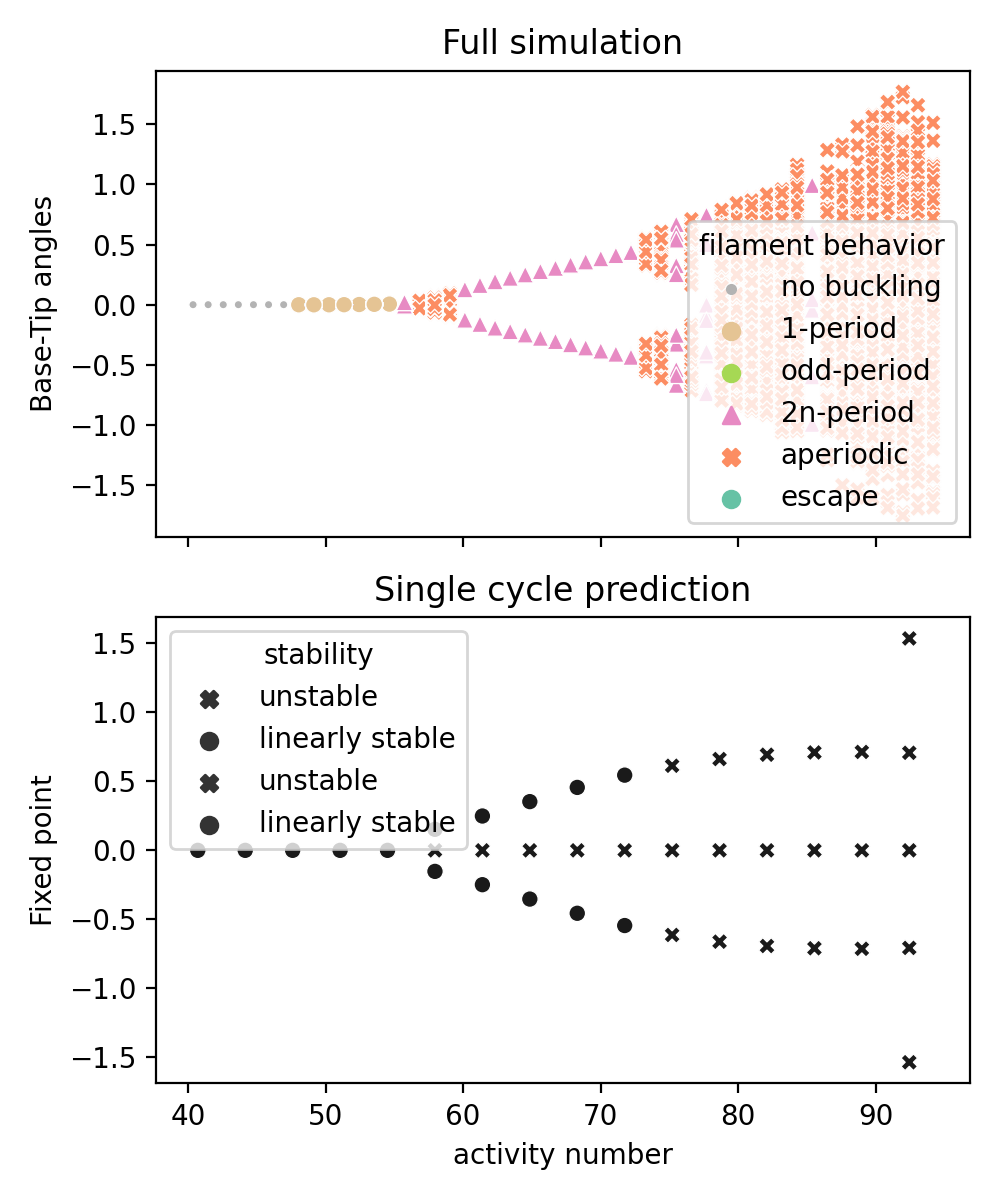

In [122]:
categories = ['no buckling', '1-period', 'odd-period','2n-period','aperiodic','escape']
markers = {'no buckling':'.', '1-period':'o','2n-period':'^','aperiodic':'X'}

cmap = plt.cm.get_cmap('Set2_r', 255)
linear_array = np.linspace(0,1,len(categories))
colors={}
for ii, cat in enumerate(categories):
    
    colors[cat]=cmap(linear_array[ii])
                           
save = True
style_parameter = 'filament behavior'
parameter = 'activity number'


title = 'Bifurcation plot_predicted_vs_fullSim'

fig, (ax0, ax1) = plt.subplots(figsize=(5,6), nrows=2, ncols = 1, sharex=True)
sns.scatterplot(data = df, x = parameter, y = 'Base-Tip angles', hue = style_parameter, style = style_parameter, 
                estimator = None, legend= True, rasterized = True, hue_order = categories, markers = markers, 
                palette = colors, ax = ax0)

sns.scatterplot(data = df_combined, x = parameter, y = 'Fixed point', 
                markers = {'linearly stable':'o','unstable':'X'},style = 'stability',color = 'k', ax=ax1)

sns.scatterplot(data = df_combined, x = parameter, y = 'Fixed points -ve', 
                markers = {'linearly stable':'o','unstable':'X'},style = 'stability', color = 'k', ax=ax1)

ax0.set_title('Full simulation')
ax1.set_title('Single cycle prediction')

plt.tight_layout()

if(save):
    plt.savefig(os.path.join(publication_figures, title + '.png'), dpi = 300)
    plt.savefig(os.path.join(publication_figures, title + '.svg'), dpi = 300)
plt.show()

In [82]:
df

,activity number,Base-Tip angles,period,filament behavior,Base-tip angles (deg)
0,52.443143,0.001339,1,1-period,0.076697
1,52.443143,0.001327,1,1-period,0.076021
2,52.443143,0.001329,1,1-period,0.076156
3,52.443143,0.001354,1,1-period,0.077584
4,52.443143,0.001348,1,1-period,0.077211
...,...,...,...,...,...
20045,83.195143,0.712061,aperiodic,aperiodic,40.798079
20046,83.195143,-0.785161,aperiodic,aperiodic,-44.986391
20047,83.195143,-0.045678,aperiodic,aperiodic,-2.617164
20048,83.195143,-0.579869,aperiodic,aperiodic,-33.224070
